In [1]:
# Custom Imports
from polymer_utils import general, filetree, molutils
from polymer_utils import simulation as polysim

from polymer_utils import charging
from polymer_utils.charging.types import AtomIDMap, ResidueChargeMap
from polymer_utils.charging.residues import ChargedResidue

from polymer_utils.representation import PolymerDir, PolymerDirManager
from polymer_utils.representation import LOGGER as polylogger
from polymer_utils.solvation.solvents import WATER_TIP3P
from polymer_utils.logutils import config_mlf_handler
from polymer_utils.graphics import rdkdraw

# General Imports
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL.Image import Image # for typing
from datetime import datetime

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# File I/O
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree

# Logging and Shell
from IPython.display import clear_output
import subprocess
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.units import unit
from openff.interchange import Interchange

from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openmm.openmm import MonteCarloBarostat
from openff.toolkit.utils.exceptions import ConformerGenerationError
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper, AmberToolsToolkitWrapper

from openmm import LangevinMiddleIntegrator, Context
from openmm.vec3 import Vec3
from openmm.app import Simulation, PDBReporter, StateDataReporter

from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# Static Paths
RESOURCE_PATH = Path('resources')
COLL_PATH = Path('Collections')
COMPAT_PDB_PATH = Path('compatible_pdbs')
SIMPLE_POLY_PATH = COMPAT_PDB_PATH / 'simple_polymers'

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [93]:
from collections import defaultdict

mp_prior = SIMPLE_POLY_PATH / 'simple_polymers_monomers_prior'
mp_updated = SIMPLE_POLY_PATH / 'simple_polymers_monomers_updated'

monomers = defaultdict(dict)
pairs = (
    ('prior', mp_prior), 
    ('updated', mp_updated)
)

for (label, src_dir) in pairs:
    for path in src_dir.glob('**/*.json'):
        with path.open('r') as mp_file:
            monomers[label][path.stem] = json.load(mp_file)

all_species = set(monomers['prior'].keys()) | set(monomers['updated'].keys())
for species in all_species:
    if (spec_prior := monomers['prior'].get(species)) and (spec_updated := monomers['updated'].get(species)):
        if spec_prior['monomers'] != spec_updated['monomers']:
            print(species, '\n\t', spec_prior['monomers'], '\n\t', spec_updated['monomers'])

paam_modified 
	 {'paam': '*-[#6:2](-[#6:1](-[#1:3])(-[#1:4])-*)(-[#6:5](=[#8:6])-[#7:7](-[#1:9])-[#1:10])-[#1:8]', 'paam_TERM2': '*-[#6:2](-[#6:1](-[#1:3])(-[#1:4])-[#1:11])(-[#6:5](=[#8:6])-[#7:7](-[#1:9])-[#1:10])-[#1:8]', 'paam_TERM3': '[#6:1](-*)(-[#1:2])(-[#1:3])-[#6:5](-[#6:4](-[#1:6])(-[#1:7])-[#1:14])(-[#6:8](=[#8:9])-[#7:10](-[#1:12])-[#1:13])-[#1:11]', 'paam_TERM1': '[#6:1](-[#6:2](-[#6:5](=[#8:6])-[#7:7](-[#1:9])-[#1:10])(-[#1:8])-[#1:11])(-[#1:3])(-[#1:4])-*'} 
	 {'paam': '[#6:2](-[#6:3](-[#1:4])(-[#1:5])-[*:6])(-[#6:7](=[#8:8])-[#7:9](-[#1:10])-[#1:11])(-[#1:12])-[*:1]', 'paam_TERM2': '[#6:2](-[#6:3](-[#1:4])(-[#1:5])-[#1:6])(-[#6:7](=[#8:8])-[#7:9](-[#1:10])-[#1:11])(-[#1:12])-[*:1]', 'paam_TERM3': '[#6:2](-[#6:3](-[#1:4])(-[#1:5])-[*:6])(-[#6:7](=[#8:8])-[#7:9](-[#1:10])-[#1:11])(-[#1:12])-[#1:1]', 'paam_SPECIAL_TERM': '[#6:1](-*)(-[#1:2])(-[#1:3])-[#6:5](-[#6:4](-[#1:6])(-[#1:7])-[#1:14])(-[#6:8](=[#8:9])-[#7:10](-[#1:12])-[#1:13])-[#1:11]'}
PEO_PLGA 
	 {'peg': '*-[#6:

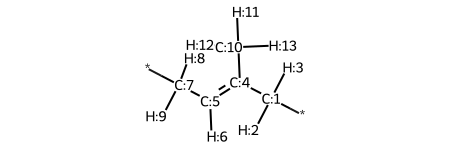

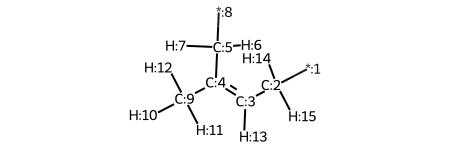

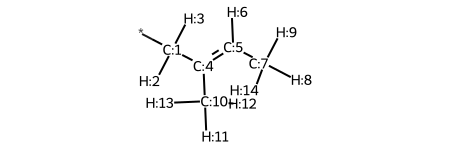

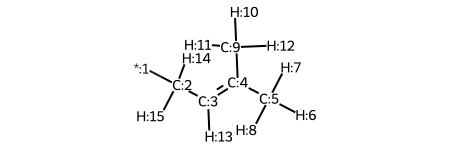

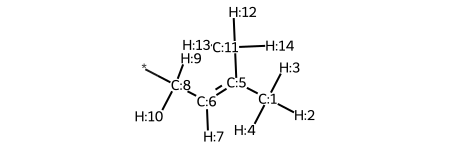

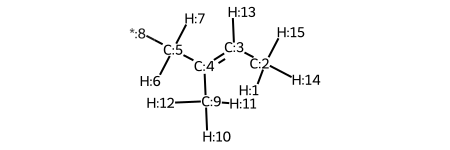

In [113]:
targ_mol = 'naturalrubber'

priors = [Chem.MolFromSmarts(SMARTS) for SMARTS in monomers['prior'][targ_mol]['monomers'].values()]
currs  = [Chem.MolFromSmarts(SMARTS) for SMARTS in monomers['updated'][targ_mol]['monomers'].values()]

for prior_rdmol, new_rdmol in zip(priors, currs):
    display(prior_rdmol)
    display(new_rdmol)
    print('\n')


## Loading and configuring available polymers

In [17]:
reset      = False
resolvate  = False 
clear_sims = False 

structure_path  = SIMPLE_POLY_PATH / 'simple_polymers_structures'
monomer_path    = SIMPLE_POLY_PATH / 'simple_polymers_monomers_updated'
collection_path = COLL_PATH / 'Polymers'
solv_template   = RESOURCE_PATH/'inp_templates'/'solv_polymer_template_box.inp'

mgr = PolymerDirManager(collection_path)
desired_solvents = (WATER_TIP3P,) # (None,)

# ------------------------------------------------------------------------------

creation_logger = logging.getLogger('polymer_setup')
loggers = [creation_logger, polylogger] 
creation_log_handler = config_mlf_handler(mgr.log_dir/f'Setup_{general.timestamp_now()}.log', loggers, writemode='a')

if reset:
    mgr.purge_collection(really=True) 

if not mgr.mol_dirs: # will be empty if not yet instantiated or if reset prior
    mgr.populate_collection(struct_dir=structure_path, monomer_dir=monomer_path)

    mgr.solvate_collection(desired_solvents, template_path=solv_template  , exclusion=1*nanometer)

if clear_sims:
    mgr.purge_sims(really=True)

creation_logger.info(f'Completed creation of collection "{collection_path.name}"')
creation_log_handler.remove_from_loggers(*loggers)

INFO:polymer_setup:Completed creation of collection "Polymers"


Text(0.5, 1.0, 'polyvinylchloride_solv_water')

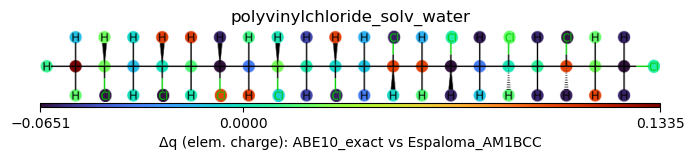

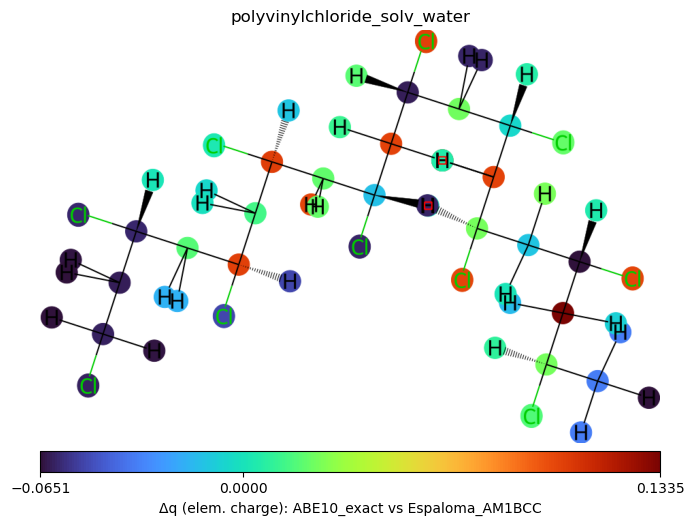

In [88]:
pdir = mgr.mol_dirs['polyvinylchloride_solv_water']

fig1, ax1 = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap=plt.get_cmap('turbo'), converter=molutils.RDCONVERTER_REGISTRY['InChI'])
fig2, ax2 = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap=plt.get_cmap('turbo'), converter=molutils.RDCONVERTER_REGISTRY['SMARTS'])

ax1.set_title(pdir.mol_name)
ax2.set_title(pdir.mol_name)

In [91]:
pdir.__dict__

{'parent_dir': PosixPath('Collections/Polymers/polyvinylchloride'),
 'mol_name': 'polyvinylchloride_solv_water',
 'charges': {'Espaloma_AM1BCC': array([-0.07287662, -0.12177933,  0.13167938,  0.10097179, -0.20774876,
         -0.12317329,  0.08538066,  0.08538066, -0.04435294, -0.19960597,
          0.10209384, -0.11541372, -0.04632714, -0.199606  ,  0.10209384,
          0.130541  ,  0.130541  , -0.1154137 , -0.04632719,  0.10209386,
         -0.199606  ,  0.13054098,  0.13054098,  0.13167938, -0.11541369,
         -0.04632715, -0.199606  ,  0.10209384,  0.13054098,  0.13054098,
         -0.1154137 ,  0.13054098, -0.04632718, -0.1154137 ,  0.13054098,
          0.13054098, -0.199606  ,  0.10209383, -0.04632715, -0.199606  ,
          0.10209386, -0.1154137 , -0.04632714, -0.11477526,  0.13054098,
          0.13054098,  0.10209385, -0.19960597,  0.130541  ,  0.130541  ,
         -0.05006136, -0.19966266,  0.10246026,  0.13054098, -0.11111687,
         -0.07031082, -0.20678654,  0.09134

In [90]:
pdir.subdirs

[PosixPath('Polymers/polyvinylchloride/polyvinylchloride_solv_water/structures'),
 PosixPath('Polymers/polyvinylchloride/polyvinylchloride_solv_water/monomers'),
 PosixPath('Polymers/polyvinylchloride/polyvinylchloride_solv_water/SDF'),
 PosixPath('Polymers/polyvinylchloride/polyvinylchloride_solv_water/FF'),
 PosixPath('Polymers/polyvinylchloride/polyvinylchloride_solv_water/MD'),
 PosixPath('Polymers/polyvinylchloride/polyvinylchloride_solv_water/checkpoint'),
 PosixPath('Polymers/polyvinylchloride/polyvinylchloride_solv_water/logs')]

In [89]:
from shutil import copytree

clone_name = f'{pdir.mol_name}_clone'
clone_dir = PolymerDir(pdir.parent, mol_name=clone_name)

copytree(pdir.path, pdir.parent_dir/f'{pdir.mol_name}_clone')

PosixPath('Collections/Polymers/polyvinylchloride/polyvinylchloride_solv_water_clone')

## Charge/Sim loop V1 proper

In [ ]:
# DEFINE TARGET MOLECULES AND FORCEFIELD
# sample_mols = mols_to_use[:3]
sample_mols = ['polyvinylchloride']
main_ff_xml = CORE_PATH/'force_fields'/'openff_unconstrained-2.0.0.offxml'

# CHARGING PARAMETERS
toolkit = 'OpenEye Toolkit'
partial_charge_method = 'am1bccelf10'

# CHARGING / SIM LOOP BEHAVIOR
overwrite_ff_xml   = True
overwrite_chg_json = True
distrib_mono_charges = True
run_sims = True
strict = True
verbose = False

# SIMULATION PARAMETERS 
temperature = 300 * kelvin
friction_coeff = 1/picosecond

sim_time = 0.001 * nanosecond #5 * nanosecond 
timestep = 1 * femtosecond
num_samples = 100 #2_000

# AUXILIARY PRE-FLIGHT CALCULATIONS
sample_dirs = {
    mol_name : mgr.mol_dirs.get(mol_name)
        for mol_name in sample_mols
}
action_str = f'Charging{" & simulation" if run_sims else ""}'

num_steps   = round(sim_time / timestep)
record_freq = round(num_steps / num_samples)
num_mols = len(sample_dirs)
print(num_steps, record_freq)

In [ ]:
chg_logger = logging.getLogger(charging.__name__)

def create_pickled_cmol(mol_dir : PolymerDir, toolkit : str, partial_charge_method : str, strict : bool=True, verbose : bool=False) -> None:
    '''Ensure that a pickled, charged molecule exists for the mol directory - perform charging with method of choice if none exists'''
    pickle_path = mol_dir.pkl/f'{mol_dir.mol_name}.pkl'

    chg_logger.info(f'Loading topology and molecule via graph match...')
    mol = mol_dir.largest_offmol_matched(strict=strict, verbose=verbose, topo_only=True)
    chg_logger.info(f'Charging {mol_dir.mol_name} via {toolkit}-{partial_charge_method}...')
    cmol = charging.charging.generate_molecule_charges(mol, toolkit=toolkit, partial_charge_method=partial_charge_method) 

    with pickle_path.open('wb') as pickle_file: # write charged molecule to pickle to avoid constantly redoing AM1
        pickle.dump(cmol, pickle_file)

    mol_dir.info.pickle_file = pickle_path # ensure change is reflected in directory info
    mol_dir.to_file() # record all changes to disc

def create_chg_avg_mono(mol_dir : PolymerDir, distrib_mono_charges : bool=True) -> tuple[list[ChargedResidue], AtomIDMap]:
    '''Create a charge-averaged monomer file from an existing monomer spec file and a charged OFF Molecule'''
    chg_logger.info('Unpickling charged Molecule for charge averaging...')
    with mol_dir.info.pickle_file.open('rb') as pickle_file: 
        cmol = pickle.load(pickle_file) # load AM1-charged molecule from file (must exist by this point in loop)

    chg_logger.info(f'Averaging charges over {mol_dir.mol_name} residues...')
    avgs, atom_id_mapping = charging.averaging.get_averaged_charges(cmol, monomer_data=mol_dir.monomer_data, distrib_mono_charges=distrib_mono_charges) # average charges over unique residues
    mono_chgs = {avgd_res.residue_name : avgd_res.charges for avgd_res in avgs}
    
    chg_logger.info(f'Writing new charged JSON monomer file...')
    mol_dir.create_charged_monomer_file(mono_chgs)

    return avgs, atom_id_mapping

def create_off_xml(mol_dir : PolymerDir, xml_src : Path) -> tuple[ForceField, list[LibraryChargeHandler]]:
    '''Generate an OFF force field with molecule-specific (and solvent specific, if applicable) Library Charges appended'''
    ff_path = mol_dir.FF/f'{mol_dir.mol_name}.offxml' # path to output library charges to
    chg_logger.info('Writing new force field OFFXML file')
    forcefield, lib_chgs = charging.averaging.write_lib_chgs_from_mono_data(mol_dir.monomer_data_charged, xml_src, output_path=ff_path)

    if mol_dir.info.solvent is not None:
        chg_logger.info('Associated solvent found, merging Library-Charged force field with solvent force field...')
        forcefield = ForceField(ff_path, mol_dir.info.solvent.forcefield_file, allow_cosmetic_attributes=True) # use both the polymer-specific xml and the solvent FF xml to make hybrid forcefield
        forcefield.to_file(ff_path)

    mol_dir.info.ff_file = ff_path # ensure change is reflected in directory info
    mol_dir.to_file() # record all changes to disc

    return forcefield, lib_chgs

In [ ]:
# BEGIN CHARGING / SIM LOOP - Perform charge averaging on all target molecules which don't already have averaged LCs; Load forcefield for those which already do 
main_logger = logging.getLogger(__name__)
loggers = [main_logger, chg_logger]
main_log_handler = config_mlf_handler(mgr.log_dir/f'Polymer_battery_{general.timestamp_now()}.log', loggers, writemode='a')

main_logger.info(f'Beginning {action_str} loop...\n')
for i, (mol_name, mol_dir) in enumerate(sample_dirs.items()):
    # 0) LOAD MOLECULE AND TOPOLOGY, ATTEMPT TO APPLY LIBRARY CHARGES
    start_time = datetime.now()
    main_logger.info(f'Current molecule: "{mol_name}" ({i + 1}/{num_mols})') # +1 converts to more human-readable 1-index for step count
    polymer_log_handler = config_mlf_handler(mol_dir.logs/f'{general.timestamp_now()}.log', loggers, writemode='w') # NOTE : order matters, initial main logger call above should not record to local polymer log
    if not mol_dir.has_monomer_data:
        raise FileExistsError(f'No monomer JSONs found for {mol_name}')
    
    # 1) ENSURING AN AM1-BCC-ELF10-CHARGED MOLECULE EXISTS (IN PICKLE FORM). WILL RECHARGE IF NONE EXISTS
    if (mol_dir.info.pickle_file is None):
        main_logger.warning('(1-precheck) Generating new pickled charged OpenFF Molecule...')
        try:
            create_pickled_cmol(mol_dir, toolkit, partial_charge_method, strict, verbose)
        except ConformerGenerationError:
            main_logger.error('Could not successfully generate conformers\n')
            continue 
    main_logger.info('(1) Found pickled charged molecule...')
    
    # 2) CREATE JSON WITH AVERAGED CHARGES IF ONE DOES NOT ALREADY EXIST
    if (mol_dir.info.monomer_file_chgd is None) or overwrite_chg_json: # can only reach this branch if a json is present but isn't identified as charged within the PolymerDir
        main_logger.warning('(2-precheck) Generating new charged monomer JSON...')
        create_chg_avg_mono(mol_dir, distrib_mono_charges=distrib_mono_charges)
    main_logger.info('(2) Found charged monomer JSON...')

    # 3) CREATE FORCE FIELD XML WITH MONOMER-BASED LIBRARY CHARGE ENTRIES
    if (mol_dir.info.ff_file is None) or overwrite_ff_xml: # can only reach if a charged monomer json already exists
        main_logger.warning('(3-precheck) Generating new Force Field XML with Library Charges...')
        create_off_xml(mol_dir, xml_src=main_ff_xml)
    main_logger.info('(3) Found Force Field file with Library Charges...')

    # 4) RUN OpenMM SIMULATION FOR TARGET MOLECULE
    if run_sims:
        main_logger.info('(4) Preparing simulation...')
        output_folder = mol_dir.make_res_dir()
        sim_log_handler = config_mlf_handler(output_folder/f'{mol_dir.mol_name} simulation.log', loggers)

        main_logger.info('Loading Topology...')
        openff_topology = mol_dir.openff_topology_matched(strict=strict, verbose=verbose, topo_only=True)
        openff_topology.box_vectors = mol_dir.box_vectors.in_units_of(nanometer) # set box vector to allow for periodic simulation (will be non-periodic if mol_dir box vectors are unset i.e. NoneType)

        main_logger.info('Loading charged Molecule...')
        with mol_dir.info.pickle_file.open('rb') as pickle_file: 
            cmol = pickle.load(pickle_file) # load AM1-charged molecule from file (must exist by this point in loop)

        main_logger.info('Loading Force Field...')
        forcefield = ForceField(mol_dir.info.ff_file, allow_cosmetic_attributes=True)

        main_logger.info('Creating Simulation from Interchange...')
        interchange = Interchange.from_smirnoff(force_field=forcefield, topology=openff_topology, charge_from_molecules=[cmol]) # generate Interchange with new library charges prior to writing to file
        integrator  = LangevinMiddleIntegrator(temperature, friction_coeff, timestep)
        sim = polysim.create_simulation(interchange, integrator)
        
        main_logger.info(f'Running {sim_time} OpenMM sim at {temperature} for {num_steps} steps...')
        polysim.run_simulation(sim, output_folder=output_folder, output_name=mol_name, num_steps=num_steps, record_freq=record_freq)

        mol_dir.to_file() # ensure directory data reflects changes to files
        # filetree.startfile(output_folder)
        sim_log_handler.remove_from_loggers(*loggers)  
    
    proc_time = str(datetime.now() - start_time)
    main_logger.info(f'Successfully completed actions on {mol_name} in {proc_time}\n')
    clear_output() # for Jupyter notebooks only, can freely comment this out
    polymer_log_handler.remove_from_loggers(*loggers)  

main_logger.info(f'{action_str} loop completed')
main_log_handler.remove_from_loggers(*loggers)

## Running Sims v0

In [ ]:
mol_dirs = mgr.mol_dirs

desired_solvents = (WATER_TIP3P,) #,None)
hard_polymers = ['vulcanizedrubber', 'polyphenylenesulfone', 'polyethylene'] # pathological or otherwise difficult-to-run polymers that I've encountered
hard_polymers_solv = [
    f'{unsolv_mol}_solv_{solvent.name}'
        for solvent in desired_solvents
            for unsolv_mol in hard_polymers
]
hard_polymers.extend(hard_polymers_solv) # ensure solvated names are also included

mols_to_use = [mol_dir.mol_name
    for mol_dir in mol_dirs.values()
        if (mol_dir.mol_name not in hard_polymers)         # 1) are not manually excluded
            and (0 < mol_dir.n_atoms <= 300)               # 2) are loadable (i.e. non-zero size) but are small enough for AM1BCC (150 is speed limit, 300 is error limit)
            and (mol_dir.has_monomer_data)                 # 3) have monomer information files
            and (mol_dir.info.solvent in desired_solvents) # 4) is solvated in the specified solvents (could be None)
]

print(mols_to_use)

In [ ]:
# DEFINE TARGET MOLECULES AND FORCEFIELD
sample_mols = mols_to_use
# sample_mols = ['polyvinylchloride_solv_water']
main_ff_xml = CORE_PATH/'force_fields'/'openff_unconstrained-2.0.0.offxml'
solv_ff_xml = CORE_PATH/'force_fields'/'tip3p.offxml'

# SET CHARGING LOOP BEHAVIOR
prevent_overwrites = False # to deprecate
distrib_mono_charges = True
run_sims = True
verbose = False

# SIMULATION PARAMETERS 
temperature = 300 * kelvin
friction_coeff = 1/picosecond

sim_time = 5 * nanosecond 
timestep = 1 * femtosecond
num_samples = 2_000

In [ ]:
# PRE-FLIGHT CHECKS
sample_dirs = {
    mol_name : mol_dirs.get(mol_name)
        for mol_name in sample_mols
}

num_steps   = round(sim_time / timestep)
record_freq = round(num_steps / num_samples)
num_mols = len(sample_dirs)
print(num_steps, record_freq)

main_log_dir = POLY_PATH/'Logs'
main_log_dir.mkdir(exist_ok=True)

master_logger = setup_logger(f'Polymer_battery_{general.timestamp_now()}', outpath=main_log_dir, formatter=LOG_FORMATTER, writemode='w')
master_handler = master_logger.handlers[0]

In [ ]:
# BEGIN CHARGING / SIM LOOP - Perform charge averaging on all target molecules which don't already have averaged LCs; Load forcefield for those which already do 
for i, (mol_name, mol_dir) in enumerate(sample_dirs.items()):
    log_name = mol_name #f'{mol_name}_chg_sim_log' #{general.timestamp_now()}'
    logger = setup_logger(log_name, outpath=mol_dir.logs, writemode='a', formatter=LOG_FORMATTER)
    logger.addHandler(master_handler) # ensure output is also logged to the master

    # DEFINING PATHS, CREATING FOLDERS, AND FETCHING FILES
    pdb_path      = mol_dir.info.structure_file
    lc_path       = mol_dir.FF/f'new {mol_name} charges.offxml' # path to output library charges to
    pickle_path   = mol_dir.pkl/f'{mol_name}.pkl'
    output_folder = mol_dir.make_res_dir()

    # LOAD MOLECULE AND TOPOLOGY, ATTEMPT TO APPLY LIBRARY CHARGES
    logger.info(f'Current molecule: {mol_name} ({i + 1}/{num_mols})') # +1 converts to more human-readable 1-index for step count
    json_path = mol_dir.monomer_file_ranked
    if json_path is None:
        raise FileExistsError(f'No monomer JSONs found for {mol_name}')
    
    logger.info(f'Using monomer file "{json_path}"...')
    with json_path.open('r') as json_file:
        mono_data = json.load(json_file)

    logger.info(f'Loading and matching molecule "{mol_name}"...')
    openff_topology, _, _error = Topology.from_pdb_and_monomer_info(str(pdb_path), json_path, strict=True, verbose=verbose)
    openff_topology.box_vectors = mol_dir.box_vectors.in_units_of(nanometer) # set box vector to allow for periodic simulation (will be non-periodic if mol_dir box vectors are unset i.e. NoneType)
    mol = next(openff_topology.molecules) # get the first molecule (assumed to be the polymer of interest)

    if prevent_overwrites and lc_path.exists(): # check if library charges have already been generated for this molecule
        logger.info('Obtaining partial charges from Library Charge xml...')
        forcefield = ForceField(lc_path, solv_ff_xml, allow_cosmetic_attributes=True) # use both the polymer-specific xml and the solvent FF xml when creating the Forcefield
        
        logger.info('Unpickling charged Molecule...')
        with pickle_path.open('rb') as pickle_file: # read cmol from file if already extant
            cmol = pickle.load(pickle_file)
    else:
        # PERFORMING INITIAL AM1-BCC CHARGING, OR UNPICKLING MOLECULE IF THIS HAS ALREADY BEEN DONE
        if not pickle_path.exists():
            logger.warning('No extant pickled charged Molecule found, performing charging...')
            try:
                cmol = polychg.generate_molecule_charges(mol, partial_charge_method='am1bccelf10') # perform AM1BCC
            except ConformerGenerationError:
                logger.warning('Could not successfully generate conformers')
                continue 

            with pickle_path.open('wb') as pickle_file: # write charged molecule to pickle to avoid constantly redoing AM1
                pickle.dump(cmol, pickle_file)
            mol_dir.info.pickle_file = pickle_path
        
        logger.info('Unpickling charged Molecule...')
        with pickle_path.open('rb') as pickle_file: # read cmol from file if already extant
            cmol = pickle.load(pickle_file)

        # CHARGE AVERAGING
        logger.info(f'Averaging charges over {mol_name} residues...')
        avgs, atom_id_mapping = polychg.get_averaged_charges(cmol, monomer_data=mono_data, distrib_mono_charges=distrib_mono_charges) # average charges over unique residues

        logger.warning('Library Charge file not found OR overwrite allowed, writing new Library Charge xml...')
        forcefield, lib_chgs = polychg.write_new_library_charges(avgs, main_ff_xml, output_path=lc_path)
        mol_dir.info.ff_file = lc_path
        
        # CREATE JSON WITH AVERAGED CHARGES IF ONE DOES NOT ALREADY EXIST
        if mol_dir.info.monomer_file_chgd is None:
            logger.info('Writing new monomer JSON with charge data...')

            mono_chgs = {avgd_res.residue_name : avgd_res.charges for avgd_res in avgs}
            if mol_dir.info.solvent is not None:
                mono_data['charges'] = {**mono_chgs, **mol_dir.info.solvent.monomer_json_data['charges']} # ensure solvent "monomer" charges are also recorded

            chgd_json_path = json_path.with_name(f'{json_path.stem}_charged.json')
            chgd_json_path.touch()
            with chgd_json_path.open('w') as new_json:
                json.dump(mono_data, new_json, indent=4)
            mol_dir.info.monomer_file_chgd = chgd_json_path

    # RUN OpenMM SIMULATION FOR TARGET MOLECULE
    if run_sims:
        logger.info(f'Running {sim_time} OpenMM sim at {temperature} for {num_steps} steps...')

        forcefield = ForceField(lc_path, solv_ff_xml, allow_cosmetic_attributes=True)
        interchange = Interchange.from_smirnoff(force_field=forcefield, topology=openff_topology, charge_from_molecules=[cmol]) # generate Interchange with new library charges prior to writing to file
        integrator  = LangevinMiddleIntegrator(temperature, friction_coeff, timestep)
        
        sim = polysim.create_simulation(interchange, integrator)
        polysim.run_simulation(sim, output_folder=output_folder, output_name=mol_name, num_steps=num_steps, record_freq=record_freq)
    
    mol_dir.to_file() # ensure directory data reflects changes to files
    # filetree.startfile(output_folder)
    clear_output() # for Jupyter notebooks only, can freely comment this out
    logger.info(f'Successfully completed actions on {mol_name}\n')
    logger.removeHandler(master_handler) # free up master log handler - prevents bleed-over between multiple sim sessions

master_logger.info(f'Charging{" & simulation" if run_sims else ""} loop completed')

In [ ]:
failed_sims = lambda : set(sample_mols) - set(mgr.all_completed_sims(mol_dirs).keys())
failed_sims()

## Generating monomer files for polyamides

In [ ]:
POLYAM_PATH   = Path('compatible_pdbs/polyamides')
p = POLYAM_PATH/'smiles.json'

with p.open('r') as smiles_file:
    mono_smiles = json.load(smiles_file)
mono_smiles['TMC'] = mono_smiles['TMC'].replace('Cl', 'O[H]') # replace chlorides with oxygens present in full polymer

rdkdraw.set_rddraw_size(400, 3/2)

mono_mols, mono_smarts = {}, {}
for name, SMILES in mono_smiles.items():
    rdmol = Chem.MolFromSmiles(SMILES, sanitize=False)
    for atom in rdmol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + 1)
    
    mono_mols[name] = rdmol
    mono_smarts[name] = Chem.MolToSmarts(rdmol)

    display(rdmol)


In [ ]:
monomers = {
    'MPD_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-[H:14]):[#6:15]:1-[H:16]',
    'MPD_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-*):[#6:15]:1-[H:16]',
    'TMC_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-[#8:13]-[H:14]):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_trivalent'  : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-*', 
}

json_spec = {
    'monomers' : monomers,
    'caps' : {name : [] for name in monomers}
}

pam_mono_path = POLYAM_PATH/'polyamides.json'
with pam_mono_path.open('w') as mono_out:
    json.dump(json_spec, mono_out, indent=4)

for pam_path in POLYAM_PATH.glob('*.pdb'):
    ind_mono_path = POLYAM_PATH/f'{pam_path.stem}.json'
    with ind_mono_path.open('w') as mono_out:
        json.dump(json_spec, mono_out, indent=4)

## Testing loading of polyamides using monomer spec

In [ ]:
pam_pdbs = [path for path in POLYAM_PATH.glob('*.pdb')]

In [ ]:
pdb_file = pam_pdbs[1]

openff_topology, _, _error = Topology.from_pdb_and_monomer_info(str(pdb_file), pam_mono_path, strict=False, verbose=False)
mol = next(openff_topology.molecules)

for atom in mol.atoms:
    if not atom.metadata['already_matched']:
        print(atom.metadata)

rdkdraw.set_rddraw_size(500, 3/2)
display(mono_mols[pdb_file.stem])

## Checking molecule size discrepancies between RDKit, OpenFF Molecule.from_file, and OpenFF Molecule.from_pdb_and_monomer_info

In [ ]:
mol_sizes = {}

# RDKIT sizes
sizes = {}
for path in POLY_PDB_PATH.glob('**/*.pdb'):
    try:
        sizes[path.stem] = Chem.MolFromPDBFile(str(path), removeHs=False).GetNumAtoms()
    except Exception as e:
        print(path.name, e)
sizes = general.sort_dict_by_values(sizes)
mol_sizes['rdkit'] = sizes

# OpenFF sizes
sizes2 = {}
for path in POLY_PDB_PATH.glob('**/*.pdb'):
    try:
        sizes2[path.stem] = len(Molecule.from_file(path, toolkit_registry=polychg.TOOLKITS['openeye']()).atoms)
    except Exception as e:
        print(path.stem, ' failed', e)
mol_sizes['openff_file'] = sizes2

# Pre-computed sizes from old workflow
q = Path('Available Polymers.json')
with q.open('r') as file:
    mol_sizes['openff_pdb_mono'] = json.load(file)

In [ ]:
names = {mol_name for sizes in mol_sizes.values() for mol_name in sizes}
header = {'Species' : list(mol_sizes.keys())}
compare = {
    mol_name : [sizes.get(mol_name) for sizes in mol_sizes.values()]
        for mol_name in names
}
compare = {k : compare[k] for k in sorted(compare)}
compare = {**header, **compare}


for species, sizes in compare.items():
    if len(set(sizes)) > 1:
        print(species, sizes)

compare        

## Checking which force field XMLs are non-unique

In [ ]:
ff_dir = CORE_PATH/'force_fields'

dat = []
for ff_xml in ff_dir.iterdir():
    with ff_xml.open('r') as file:
        info = file.read()
        # if info in dat:
        print(ff_xml.name)
        # else:
        dat.append(info)

len(set(dat))

In [ ]:
np.array([
    [i == j
        for i in dat]
            for j in dat
])

## Some other section